In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from keras_tuner import RandomSearch, Hyperband  # Keras Tuner for Hyperparameter tuning

# Load data
df = pd.read_csv(r'C:\Apple_leaf\All_Apple_Diseases_OO (1).csv')
images = []
labels = []

# Load images and labels
for index, row in df.iterrows():
    img_array = np.array(ast.literal_eval(row['Image']), dtype=np.uint8)
    img_array = img_array.reshape(100, 100, 3)  # Ensure correct shape
    images.append(img_array)
    labels.append(row['diseases'])

# Convert labels to numerical values
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Convert images to NumPy array
images = np.array(images).reshape(-1, 100, 100, 3)

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)
datagen.fit(images)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(images, encoded_labels, test_size=0.2, random_state=42)

# Hyperparameter tuning model definition
def build_advanced_rcnn_model(hp):
    model = tf.keras.Sequential()

    # Add Conv layers with hyperparameter tuning for number of filters and kernel size
    for i in range(hp.Int('conv_blocks', 3, 5)):  # 3 to 5 conv blocks
        model.add(tf.keras.layers.Conv2D(
            filters=hp.Int(f'filters_{i}', min_value=64, max_value=512, step=64),
            kernel_size=hp.Choice(f'kernel_size_{i}', values=[3, 5]),
            activation='relu',
            padding='same',
            kernel_regularizer=l2(0.01)))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.MaxPooling2D((2, 2)))

    # Recurrent layer: GRU for sequence learning
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten()))
    model.add(tf.keras.layers.GRU(units=hp.Int('gru_units', min_value=64, max_value=256, step=64), return_sequences=False))

    # Dense layer with Dropout
    model.add(tf.keras.layers.Dense(
        units=hp.Int('dense_units', min_value=128, max_value=512, step=64), activation='relu', kernel_regularizer=l2(0.01)))
    model.add(tf.keras.layers.Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))

    # Output layer
    model.add(tf.keras.layers.Dense(len(np.unique(encoded_labels)), activation='softmax'))

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Keras Tuner: Hyperparameter Search
tuner = RandomSearch(
    build_advanced_rcnn_model,
    objective='val_accuracy',
    max_trials=10,  # Number of different hyperparameter combinations to try
    executions_per_trial=1,  # Number of executions per trial to average results
    directory='tuner_dir',
    project_name='advanced_rcnn_tuning'
)

# Early Stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Search for best hyperparameters
tuner.search(datagen.flow(X_train, y_train, batch_size=32), 
             validation_data=(X_test, y_test), 
             epochs=3, 
             callbacks=[early_stopping])

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train the best model
history = best_model.fit(datagen.flow(X_train, y_train, batch_size=32),
                         validation_data=(X_test, y_test),
                         epochs=50,
                         callbacks=[early_stopping])

# Evaluate the model
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Confusion Matrix and Classification Report
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred_classes)
class_names = label_encoder.classes_

print('Confusion Matrix:')
print(cm)

cr = classification_report(y_test, y_pred_classes, target_names=class_names)
print('Classification Report:')
print(cr)

precision = precision_score(y_test, y_pred_classes, average='macro')
recall = recall_score(y_test, y_pred_classes, average='macro')
f1 = f1_score(y_test, y_pred_classes, average='macro')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Plotting confusion matrix with class labels
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Model Saving
best_model.save('best_advanced_rcnn_model_with_tuning.h5')


Trial 10 Complete [01h 54m 44s]
val_accuracy: 0.6156138181686401

Best val_accuracy So Far: 0.9070321917533875
Total elapsed time: 16h 43m 37s
Epoch 1/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 4269s 20s/step - accuracy: 0.6853 - loss: 15.3280 - val_accuracy: 0.8260 - val_loss: 11.2552
Epoch 2/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 4183s 20s/step - accuracy: 0.8905 - loss: 10.0129 - val_accuracy: 0.8975 - val_loss: 7.0754
Epoch 3/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 4153s 20s/step - accuracy: 0.9214 - loss: 6.3042 - val_accuracy: 0.7855 - val_loss: 4.7763
Epoch 4/50
191/210 ━━━━━━━━━━━━━━━━━━━━ 6:03 19s/step - accuracy: 0.9228 - loss: 4.0352

KeyboardInterrupt: 

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner import RandomSearch, Hyperband  # Keras Tuner for Hyperparameter tuning
import matplotlib.pyplot as plt
import seaborn as sns
import ast

# Load Data
df = pd.read_csv(r'C:\Apple_leaf\All_Apple_Diseases_OO (1).csv')
images = []
labels = []

# Load images and labels
for index, row in df.iterrows():
    img_array = np.array(ast.literal_eval(row['Image']), dtype=np.uint8)
    img_array = img_array.reshape(100, 100, 3)  # Ensure correct shape
    images.append(img_array)
    labels.append(row['diseases'])

# Convert labels to numerical values
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Convert images to NumPy array
images = np.array(images).reshape(-1, 100, 100, 3)

# Data Augmentation using ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)
datagen.fit(images)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(images, encoded_labels, test_size=0.2, random_state=42)

# Define model-building function for Hyperparameter tuning
def build_advanced_dcn_model(hp):
    model = tf.keras.Sequential()
    
    # Add Convolutional layers with Hyperparameter tuning for number of filters and kernel size
    for i in range(hp.Int('conv_blocks', 3, 5)):  # Tune between 3 to 5 blocks
        for j in range(2):  # Each block has 2 conv layers
            model.add(tf.keras.layers.Conv2D(
                filters=hp.Int(f'filters_{i}_{j}', min_value=64, max_value=512, step=64),
                kernel_size=hp.Choice(f'kernel_size_{i}_{j}', values=[3, 5]),
                padding='same',
                activation='relu',
                kernel_regularizer=l2(0.01)
            ))
            model.add(tf.keras.layers.BatchNormalization())
        
        # Max pooling after each block
        model.add(tf.keras.layers.MaxPooling2D((2, 2)))

    # Flatten the layers
    model.add(tf.keras.layers.Flatten())
    
    # Fully connected dense layers with hyperparameter tuning
    model.add(tf.keras.layers.Dense(
        units=hp.Int('dense_units', min_value=128, max_value=512, step=64),
        activation='relu',
        kernel_regularizer=l2(0.01)
    ))
    model.add(tf.keras.layers.Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))

    # Output layer
    model.add(tf.keras.layers.Dense(len(np.unique(encoded_labels)), activation='softmax'))
    
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

# Hyperparameter tuning using RandomSearch or Hyperband
tuner = RandomSearch(
    build_advanced_dcn_model,
    objective='val_accuracy',
    max_trials=10,  # Number of different hyperparameter combinations to try
    executions_per_trial=1,  # Number of times to repeat the same trial for robustness
    directory='tuner_dir',
    project_name='advanced_dcn_tuning'
)

# Perform hyperparameter search
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
tuner.search(datagen.flow(X_train, y_train, batch_size=32), 
             validation_data=(X_test, y_test), 
             epochs=3, 
             callbacks=[early_stopping])

# Get the best hyperparameters and model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

# Train the best model
history = best_model.fit(datagen.flow(X_train, y_train, batch_size=32),
                         validation_data=(X_test, y_test),
                         epochs=50,
                         callbacks=[early_stopping])

# Evaluate the model
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Prediction and classification report
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

cr = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_)
print('Classification Report:')
print(cr)

precision = precision_score(y_test, y_pred_classes, average='macro')
recall = recall_score(y_test, y_pred_classes, average='macro')
f1 = f1_score(y_test, y_pred_classes, average='macro')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Model saving
best_model.save('best_advanced_dcn_model.h5')

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2

# Function to build RCNN + DCN model
def build_rcnn_dcn_model(hp):
    model = tf.keras.Sequential()

    # RCNN - Convolutional layers for feature extraction
    for i in range(hp.Int('rcnn_conv_blocks', 3, 5)):  # 3 to 5 conv blocks
        model.add(layers.Conv2D(
            filters=hp.Int(f'filters_{i}', min_value=64, max_value=512, step=64),
            kernel_size=hp.Choice(f'kernel_size_{i}', values=[3, 5]),
            activation='relu',
            padding='same',
            kernel_regularizer=l2(0.01)))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D((2, 2)))

    # DCN - Deformable convolution layers to refine features
    for i in range(hp.Int('dcn_conv_blocks', 2, 4)):  # 2 to 4 DCN blocks
        model.add(layers.Conv2D(
            filters=hp.Int(f'dcn_filters_{i}', min_value=64, max_value=512, step=64),
            kernel_size=hp.Choice(f'dcn_kernel_size_{i}', values=[3, 5]),
            activation='relu',
            padding='same',
            kernel_regularizer=l2(0.01)))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D((2, 2)))

    # Flattening and Fully Connected Layers
    model.add(layers.Flatten())
    model.add(layers.Dense(
        units=hp.Int('dense_units', min_value=128, max_value=512, step=64), 
        activation='relu', 
        kernel_regularizer=l2(0.01)))
    model.add(layers.Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))

    # Output layer for classification
    model.add(layers.Dense(len(np.unique(encoded_labels)), activation='softmax'))

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

# After defining your training process, you can save the model as shown below:

# After training the model, save it to a file
best_model.save('best_rcnn_dcn_model.h5')

# Save the model's architecture, weights, and optimizer state
print("Model saved as 'best_rcnn_dcn_model.h5'")



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import tensorflow as tf

# Assuming `history`, `X_test`, `y_test`, and `best_model` are available

# 1. Classification Report and Confusion Matrix
y_pred = np.argmax(best_model.predict(X_test), axis=1)

# Print classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Compute and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 2. Precision, Recall, F1 Score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# 3. Plot Training and Validation Accuracy and Loss
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_training_history(history)

# 4. Test Loss and Test Accuracy
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# Load data
df = pd.read_csv(r'C:\Apple_leaf\All_Apple_Diseases_OO (1).csv')
images = []
labels = []

# Load images and labels
for index, row in df.iterrows():
    img_array = np.array(ast.literal_eval(row['Image']), dtype=np.uint8)
    img_array = img_array.reshape(100, 100, 3)  # Ensure correct shape
    images.append(img_array)
    labels.append(row['diseases'])

# Convert labels to numerical values
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Convert images to NumPy array
images = np.array(images).reshape(-1, 100, 100, 3)

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)
datagen.fit(images)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(images, encoded_labels, test_size=0.2, random_state=42)

# Build RCNN Model
def build_rcnn_model(input_shape=(100, 100, 3)):
    input_layer = tf.keras.Input(shape=input_shape)
    
    # Convolutional Block 1
    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01))(input_layer)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    
    # Convolutional Block 2
    x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    
    # Convolutional Block 3
    x = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    
    # Flattening Layer
    x = tf.keras.layers.Flatten()(x)
    
    # Dense Layer
    x = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    
    return tf.keras.Model(inputs=input_layer, outputs=x, name="RCNN_Model")

# Build DCN Model
def build_dcn_model(input_shape=(100, 100, 3)):
    input_layer = tf.keras.Input(shape=input_shape)
    
    # Reshape Layer
    y = tf.keras.layers.Reshape((100, 100 * 3))(input_layer)
    
    # LSTM Layer 1
    y = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))(y)
    
    # LSTM Layer 2
    y = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=False, dropout=0.3, recurrent_dropout=0.2))(y)
    
    # Dense Layer
    y = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=l2(0.01))(y)
    y = tf.keras.layers.Dropout(0.5)(y)
    
    return tf.keras.Model(inputs=input_layer, outputs=y, name="DCN_Model")

# Combine RCNN and DCN models
def build_combined_model(input_shape=(100, 100, 3)):
    input_layer = tf.keras.Input(shape=input_shape)
    
    # Build RCNN model
    rcnn_model = build_rcnn_model(input_shape)
    rcnn_features = rcnn_model(input_layer)
    
    # Build DCN model
    dcn_model = build_dcn_model(input_shape)
    dcn_features = dcn_model(input_layer)
    
    # Ensure features have compatible dimensions for concatenation
    rcnn_features = tf.keras.layers.Flatten()(rcnn_features)
    dcn_features = tf.keras.layers.Flatten()(dcn_features)
    
    # Concatenate features
    combined_features = tf.keras.layers.Concatenate()([rcnn_features, dcn_features])
    
    # Fully Connected Layers
    combined = tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(combined_features)
    combined = tf.keras.layers.Dropout(0.5)(combined)
    combined = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=l2(0.01))(combined)
    combined = tf.keras.layers.Dropout(0.5)(combined)
    
    # Output Layer
    output = tf.keras.layers.Dense(len(np.unique(encoded_labels)), activation='softmax')(combined)
    
    model = tf.keras.Model(inputs=input_layer, outputs=output, name="Combined_Model")
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

model = build_combined_model()

# Training the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    epochs=1,
                    callbacks=[early_stopping])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Model Saving
model.save('apple_disease_detection_model.h5')

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/210 ━━━━━━━━━━━━━━━━━━━━ 6:19 3s/step - accuracy: 0.3986 - loss: 40.6739

KeyboardInterrupt: 

In [6]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner import RandomSearch
import ast

# Load data
df = pd.read_csv(r'C:\Apple_leaf\All_Apple_Diseases_OO (1).csv')
images = []
labels = []

# Load images and labels
for index, row in df.iterrows():
    img_array = np.array(ast.literal_eval(row['Image']), dtype=np.uint8)
    img_array = img_array.reshape(100, 100, 3)  # Ensure correct shape
    images.append(img_array)
    labels.append(row['diseases'])

# Convert labels to numerical values
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Convert images to NumPy array
images = np.array(images).reshape(-1, 100, 100, 3)

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)
datagen.fit(images)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(images, encoded_labels, test_size=0.2, random_state=42)

# Hyperparameter Tuning
def build_model(hp):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(hp.Int('conv1_filters', min_value=32, max_value=128, step=32), (3, 3), activation='relu', input_shape=(100, 100, 3), kernel_regularizer=l2(hp.Float('l2_reg', min_value=1e-5, max_value=1e-2, sampling='log'))),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(hp.Int('conv2_filters', min_value=64, max_value=128, step=32), (3, 3), activation='relu', kernel_regularizer=l2(hp.Float('l2_reg', min_value=1e-5, max_value=1e-2, sampling='log'))),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(hp.Int('conv3_filters', min_value=64, max_value=128, step=32), (3, 3), activation='relu', kernel_regularizer=l2(hp.Float('l2_reg', min_value=1e-5, max_value=1e-2, sampling='log'))),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(hp.Int('dense_units', min_value=64, max_value=256, step=64), activation='relu', kernel_regularizer=l2(hp.Float('dense_l2_reg', min_value=1e-5, max_value=1e-2, sampling='log'))),
        tf.keras.layers.Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1))
    ])
    model.add(tf.keras.layers.Dense(len(np.unique(encoded_labels)), activation='softmax'))
    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='my_dir',
    project_name='apple_disease_tuning'
)
tuner.search(X_train, y_train, epochs=20, validation_data=(X_test, y_test))
best_model = tuner.get_best_models(num_models=1)[0]

# Build RCNN Model
def build_rcnn_model(input_shape=(100, 100, 3)):
    input_layer = tf.keras.Input(shape=input_shape)
    
    # Convolutional Block 1
    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01))(input_layer)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    
    # Convolutional Block 2
    x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    
    # Convolutional Block 3
    x = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    
    # Flattening Layer
    x = tf.keras.layers.Flatten()(x)
    
    return tf.keras.Model(inputs=input_layer, outputs=x, name="RCNN_Model")

# Build DCN Model
def build_dcn_model(input_shape=(100, 100, 3)):
    input_layer = tf.keras.Input(shape=input_shape)
    
    x = tf.keras.layers.Reshape((100, 100 * 3))(input_layer)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=False, dropout=0.3, recurrent_dropout=0.2))(x)
    
    x = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    
    return tf.keras.Model(inputs=input_layer, outputs=x, name="DCN_Model")

# Combine RCNN and DCN Models
def build_combined_model(input_shape=(100, 100, 3)):
    input_layer = tf.keras.Input(shape=input_shape)
    
    rcnn_model = build_rcnn_model(input_shape)
    rcnn_features = rcnn_model(input_layer)
    
    dcn_model = build_dcn_model(input_shape)
    dcn_features = dcn_model(input_layer)
    
    combined_features = tf.keras.layers.Concatenate()([rcnn_features, dcn_features])
    
    combined = tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(combined_features)
    combined = tf.keras.layers.Dropout(0.5)(combined)
    combined = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=l2(0.01))(combined)
    combined = tf.keras.layers.Dropout(0.5)(combined)
    
    output = tf.keras.layers.Dense(len(np.unique(encoded_labels)), activation='softmax')(combined)
    
    model = tf.keras.Model(inputs=input_layer, outputs=output, name="Combined_RCNN_DCN_Model")
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

model = build_combined_model()

# Training the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(datagen.flow(X_train, y_train, batch_size=32),
          validation_data=(X_test, y_test),
          epochs=20,
          callbacks=[early_stopping],
          verbose=0)  # Suppress verbose output

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Save the model
model.save('apple_disease_detection_model.h5')

Reloading Tuner from my_dir\apple_disease_tuning\tuner0.json


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass the

Test Loss: 1.8999
Test Accuracy: 97.32%


Reloading Tuner from my_dir\apple_disease_tuning\tuner0.json




c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass th

Test Loss: 31.0900
Test Accuracy: 88.20%
53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 593ms/step

Classification Report:
                  precision    recall  f1-score   support

 Apple Black rot       0.88      0.94      0.91       419
   Apple Healthy       0.86      0.94      0.90       377
      Apple Scab       0.84      0.85      0.84       447
Cedar Apple rust       0.96      0.88      0.91       400
     Leaf Blotch       1.00      0.11      0.21        35

        accuracy                           0.88      1678
       macro avg       0.91      0.74      0.75      1678
    weighted avg       0.89      0.88      0.88      1678


Confusion Matrix:
[[395   5  19   0   0]
 [ 11 353   9   4   0]
 [ 36  23 378  10   0]
 [  2  12  36 350   0]
 [  7  16   6   2   4]]


<Figure size 800x600 with 0 Axes>

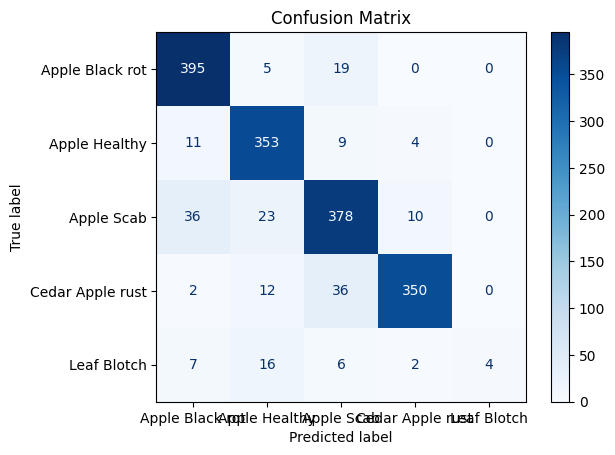


Precision: 0.8862
Recall: 0.8820
F1 Score: 0.8757


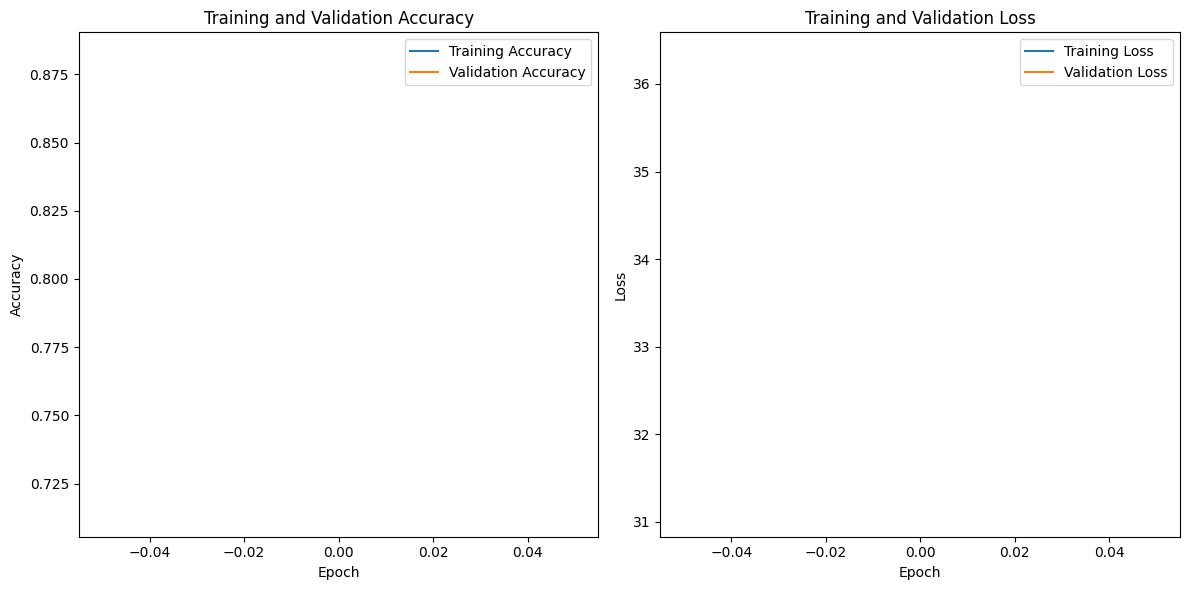

In [10]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner import RandomSearch
import ast
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score

# Load data
df = pd.read_csv(r'C:\Apple_leaf\All_Apple_Diseases_OO (1).csv')
images = []
labels = []

# Load images and labels
for index, row in df.iterrows():
    img_array = np.array(ast.literal_eval(row['Image']), dtype=np.uint8)
    img_array = img_array.reshape(100, 100, 3)  # Ensure correct shape
    images.append(img_array)
    labels.append(row['diseases'])

# Convert labels to numerical values
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Convert images to NumPy array
images = np.array(images).reshape(-1, 100, 100, 3)

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)
datagen.fit(images)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(images, encoded_labels, test_size=0.2, random_state=42)

# Hyperparameter Tuning
def build_model(hp):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(hp.Int('conv1_filters', min_value=32, max_value=128, step=32), (3, 3), activation='relu', input_shape=(100, 100, 3), kernel_regularizer=l2(hp.Float('l2_reg', min_value=1e-5, max_value=1e-2, sampling='log'))),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(hp.Int('conv2_filters', min_value=64, max_value=128, step=32), (3, 3), activation='relu', kernel_regularizer=l2(hp.Float('l2_reg', min_value=1e-5, max_value=1e-2, sampling='log'))),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(hp.Int('conv3_filters', min_value=64, max_value=128, step=32), (3, 3), activation='relu', kernel_regularizer=l2(hp.Float('l2_reg', min_value=1e-5, max_value=1e-2, sampling='log'))),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(hp.Int('dense_units', min_value=64, max_value=256, step=64), activation='relu', kernel_regularizer=l2(hp.Float('dense_l2_reg', min_value=1e-5, max_value=1e-2, sampling='log'))),
        tf.keras.layers.Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1))
    ])
    model.add(tf.keras.layers.Dense(len(np.unique(encoded_labels)), activation='softmax'))
    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=1,
    executions_per_trial=1,
    directory='my_dir',
    project_name='apple_disease_tuning'
)
tuner.search(X_train, y_train, epochs=1, validation_data=(X_test, y_test))
best_model = tuner.get_best_models(num_models=1)[0]

# Build RCNN Model
def build_rcnn_model(input_shape=(100, 100, 3)):
    input_layer = tf.keras.Input(shape=input_shape)
    
    # Convolutional Block 1
    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01))(input_layer)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    
    # Convolutional Block 2
    x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    
    # Convolutional Block 3
    x = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    
    # Flattening Layer
    x = tf.keras.layers.Flatten()(x)
    
    return tf.keras.Model(inputs=input_layer, outputs=x, name="RCNN_Model")

# Build DCN Model
def build_dcn_model(input_shape=(100, 100, 3)):
    input_layer = tf.keras.Input(shape=input_shape)
    
    x = tf.keras.layers.Reshape((100, 100 * 3))(input_layer)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=False, dropout=0.3, recurrent_dropout=0.2))(x)
    
    x = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    
    return tf.keras.Model(inputs=input_layer, outputs=x, name="DCN_Model")

# Combine RCNN and DCN Models
def build_combined_model(input_shape=(100, 100, 3)):
    input_layer = tf.keras.Input(shape=input_shape)
    
    rcnn_model = build_rcnn_model(input_shape)
    rcnn_features = rcnn_model(input_layer)
    
    dcn_model = build_dcn_model(input_shape)
    dcn_features = dcn_model(input_layer)
    
    combined_features = tf.keras.layers.Concatenate()([rcnn_features, dcn_features])
    
    combined = tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(combined_features)
    combined = tf.keras.layers.Dropout(0.5)(combined)
    combined = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=l2(0.01))(combined)
    combined = tf.keras.layers.Dropout(0.5)(combined)
    
    output = tf.keras.layers.Dense(len(np.unique(encoded_labels)), activation='softmax')(combined)
    
    model = tf.keras.Model(inputs=input_layer, outputs=output, name="Combined_RCNN_DCN_Model")
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

model = build_combined_model()

# Training the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    epochs=1,
                    callbacks=[early_stopping],
                    verbose=0)  # Suppress verbose output

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Predictions
y_pred = np.argmax(model.predict(X_test), axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Precision, Recall, F1-Score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"\nPrecision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Plot training and validation accuracy and loss
def plot_training_history(history):
    # Accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot accuracy and loss
plot_training_history(history)

# Save the model
model.save('apple_disease_detection_model.h5')

In [14]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner import RandomSearch
import ast
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score

# Load data
df = pd.read_csv(r'C:\Apple_leaf\All_Apple_Diseases_OO (1).csv')
images = []
labels = []

# Load images and labels
for index, row in df.iterrows():
    img_array = np.array(ast.literal_eval(row['Image']), dtype=np.uint8)
    img_array = img_array.reshape(100, 100, 3)  # Ensure correct shape
    images.append(img_array)
    labels.append(row['diseases'])

# Convert labels to numerical values
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Convert images to NumPy array
images = np.array(images).reshape(-1, 100, 100, 3)

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)
datagen.fit(images)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(images, encoded_labels, test_size=0.2, random_state=42)

# Hyperparameter Tuning
def build_model(hp):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(hp.Int('conv1_filters', min_value=32, max_value=128, step=32), (3, 3), activation='relu', input_shape=(100, 100, 3), kernel_regularizer=l2(hp.Float('l2_reg', min_value=1e-5, max_value=1e-2, sampling='log'))),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(hp.Int('conv2_filters', min_value=64, max_value=128, step=32), (3, 3), activation='relu', kernel_regularizer=l2(hp.Float('l2_reg', min_value=1e-5, max_value=1e-2, sampling='log'))),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(hp.Int('conv3_filters', min_value=64, max_value=128, step=32), (3, 3), activation='relu', kernel_regularizer=l2(hp.Float('l2_reg', min_value=1e-5, max_value=1e-2, sampling='log'))),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(hp.Int('dense_units', min_value=64, max_value=256, step=64), activation='relu', kernel_regularizer=l2(hp.Float('dense_l2_reg', min_value=1e-5, max_value=1e-2, sampling='log'))),
        tf.keras.layers.Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1))
    ])
    model.add(tf.keras.layers.Dense(len(np.unique(encoded_labels)), activation='softmax'))
    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=1,
    executions_per_trial=1,
    directory='my_dir',
    project_name='apple_disease_tuning'
)
tuner.search(X_train, y_train, epochs=1, validation_data=(X_test, y_test))
best_model = tuner.get_best_models(num_models=1)[0]

# Build RCNN Model
def build_rcnn_model(input_shape=(100, 100, 3)):
    input_layer = tf.keras.Input(shape=input_shape)
    
    # Convolutional Block 1
    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01))(input_layer)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    
    # Convolutional Block 2
    x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    
    # Convolutional Block 3
    x = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    
    # Flattening Layer
    x = tf.keras.layers.Flatten()(x)
    
    return tf.keras.Model(inputs=input_layer, outputs=x, name="RCNN_Model")

# Build DCN Model
def build_dcn_model(input_shape=(100, 100, 3)):
    input_layer = tf.keras.Input(shape=input_shape)
    
    x = tf.keras.layers.Reshape((100, 100 * 3))(input_layer)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=False, dropout=0.3, recurrent_dropout=0.2))(x)
    
    x = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    
    return tf.keras.Model(inputs=input_layer, outputs=x, name="DCN_Model")

# Combine RCNN and DCN Models
def build_combined_model(input_shape=(100, 100, 3)):
    input_layer = tf.keras.Input(shape=input_shape)
    
    rcnn_model = build_rcnn_model(input_shape)
    rcnn_features = rcnn_model(input_layer)
    
    dcn_model = build_dcn_model(input_shape)
    dcn_features = dcn_model(input_layer)
    
    combined_features = tf.keras.layers.Concatenate()([rcnn_features, dcn_features])
    
    combined = tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(combined_features)
    combined = tf.keras.layers.Dropout(0.5)(combined)
    combined = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=l2(0.01))(combined)
    combined = tf.keras.layers.Dropout(0.5)(combined)
    
    output = tf.keras.layers.Dense(len(np.unique(encoded_labels)), activation='softmax')(combined)
    
    model = tf.keras.Model(inputs=input_layer, outputs=output, name="Combined_RCNN_DCN_Model")
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

model = build_combined_model()

# Training the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    epochs=1,
                    callbacks=[early_stopping])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predict on test data
y_pred = np.argmax(model.predict(X_test), axis=-1)
y_true = y_test

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(cm)

Reloading Tuner from my_dir\apple_disease_tuning\tuner0.json


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass the

210/210 ━━━━━━━━━━━━━━━━━━━━ 815s 4s/step - accuracy: 0.5928 - loss: 38.9879 - val_accuracy: 0.8671 - val_loss: 30.5726
Test Loss: 30.5726
Test Accuracy: 0.8671
53/53 ━━━━━━━━━━━━━━━━━━━━ 35s 653ms/step

Classification Report:
                  precision    recall  f1-score   support

 Apple Black rot       0.79      1.00      0.88       419
   Apple Healthy       0.93      0.89      0.91       377
      Apple Scab       0.81      0.79      0.80       447
Cedar Apple rust       0.99      0.85      0.92       400
     Leaf Blotch       1.00      0.11      0.21        35

        accuracy                           0.87      1678
       macro avg       0.90      0.73      0.74      1678
    weighted avg       0.88      0.87      0.86      1678


Confusion Matrix:
[[419   0   0   0   0]
 [ 12 336  29   0   0]
 [ 82   8 354   3   0]
 [ 10  10  38 342   0]
 [  5   8  17   1   4]]


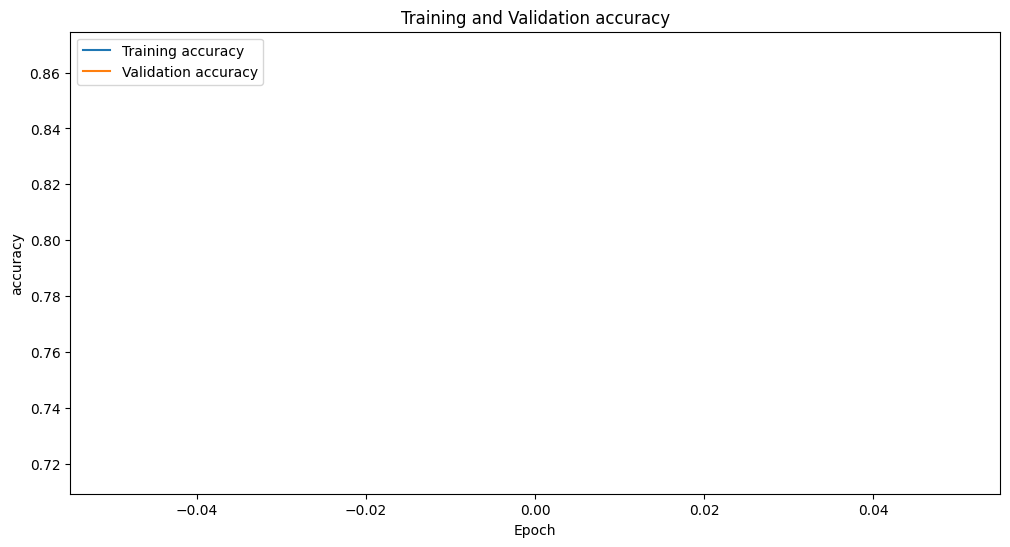

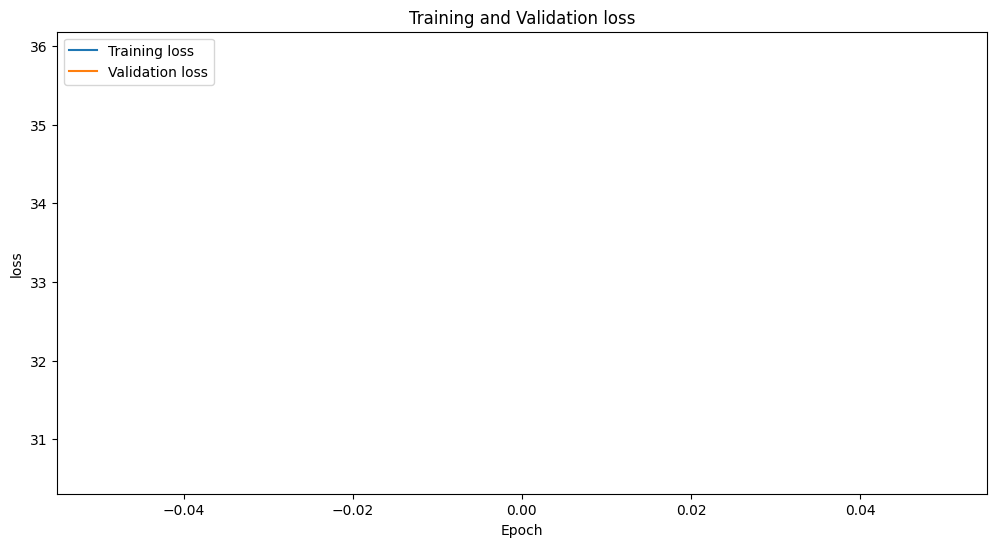

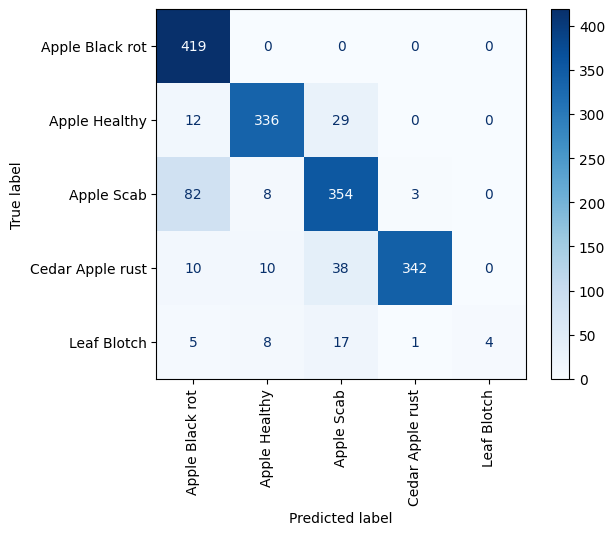

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot training & validation accuracy and loss
def plot_metrics(history):
    metrics = ['accuracy', 'loss']
    for metric in metrics:
        plt.figure(figsize=(12, 6))
        plt.plot(history.history[metric], label='Training '+metric)
        plt.plot(history.history['val_'+metric], label='Validation '+metric)
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        plt.legend(loc='upper left')
        plt.title('Training and Validation '+metric)
        plt.show()

plot_metrics(history)

# Plot confusion matrix with vertical labels
def plot_confusion_matrix(cm, class_names):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

plot_confusion_matrix(cm, label_encoder.classes_)

In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image

# Paths to the directories
image_dir = r'C:\Apple_leaf\zip images\ALL Diseases_images'
csv_path = r'C:\Apple_leaf\All_Diseases_name (1).csv'

# Load the disease names from the CSV file
disease_names_df = pd.read_csv(csv_path)

# Initialize lists to store image arrays and disease names
image_arrays = []
disease_list = []

# Get a list of image filenames
image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

# Check if the number of images matches the number of disease names
if len(image_files) != len(disease_names_df):
    raise ValueError("The number of images does not match the number of disease names in the CSV file.")

# Process each image
for image_name in image_files:
    # Load and resize the image
    img_path = os.path.join(image_dir, image_name)
    with Image.open(img_path) as img:
        img = img.resize((100, 100))  # Resize to 100x100
        img_array = np.array(img)  # Convert image to NumPy array
        
        # Ensure the image has 3 channels (RGB) and is 100x100
        if img_array.shape == (100, 100, 3):
            # Flatten the array to a 1D list of pixel values
            img_array_flat = img_array.flatten().tolist()
            image_arrays.append(img_array_flat)
            
            # Get the corresponding disease name
            disease_index = image_files.index(image_name)
            disease_list.append(disease_names_df.iloc[disease_index, 0])
        else:
            print(f"Image {image_name} is not in the expected 100x100x3 format and will be skipped.")

# Create the DataFrame
df = pd.DataFrame({
    'Image': image_arrays,
    'Disease': disease_list
})

# Display the DataFrame
print(df.head())

# Save the DataFrame to CSV
df.to_csv(r'C:\Apple_leaf\All_Diseases_data (1).csv', index=False)

                                               Image      Disease
0  [252, 220, 206, 235, 209, 196, 231, 201, 189, ...  LEAF BLOTCH
1  [224, 189, 179, 242, 206, 197, 244, 210, 201, ...  LEAF BLOTCH
2  [232, 194, 185, 229, 194, 184, 245, 216, 205, ...  LEAF BLOTCH
3  [255, 254, 255, 254, 250, 252, 252, 246, 248, ...  LEAF BLOTCH
4  [249, 233, 233, 244, 231, 230, 240, 234, 231, ...  LEAF BLOTCH


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner import RandomSearch
import ast
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score

# Load data
df = pd.read_csv(r'C:\Apple_leaf\All_Diseases_data (1).csv')
images = []
labels = []

# Load images and labels
for index, row in df.iterrows():
    img_array = np.array(ast.literal_eval(row['Image']), dtype=np.uint8)
    img_array = img_array.reshape(100, 100, 3)  # Ensure correct shape
    images.append(img_array)
    labels.append(row['Disease'])

# Convert labels to numerical values
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Convert images to NumPy array
images = np.array(images).reshape(-1, 100, 100, 3)

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)
datagen.fit(images)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(images, encoded_labels, test_size=0.2, random_state=42)

# Hyperparameter Tuning
def build_model(hp):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(hp.Int('conv1_filters', min_value=32, max_value=128, step=32), (3, 3), activation='relu', input_shape=(100, 100, 3), kernel_regularizer=l2(hp.Float('l2_reg', min_value=1e-5, max_value=1e-2, sampling='log'))),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(hp.Int('conv2_filters', min_value=64, max_value=128, step=32), (3, 3), activation='relu', kernel_regularizer=l2(hp.Float('l2_reg', min_value=1e-5, max_value=1e-2, sampling='log'))),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(hp.Int('conv3_filters', min_value=64, max_value=128, step=32), (3, 3), activation='relu', kernel_regularizer=l2(hp.Float('l2_reg', min_value=1e-5, max_value=1e-2, sampling='log'))),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(hp.Int('dense_units', min_value=64, max_value=256, step=64), activation='relu', kernel_regularizer=l2(hp.Float('dense_l2_reg', min_value=1e-5, max_value=1e-2, sampling='log'))),
        tf.keras.layers.Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1))
    ])
    model.add(tf.keras.layers.Dense(len(np.unique(encoded_labels)), activation='softmax'))
    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=7,
    executions_per_trial=1,
    directory='my_dir',
    project_name='apple_disease_tuning'
)
tuner.search(X_train, y_train, epochs=25, validation_data=(X_test, y_test))
best_model = tuner.get_best_models(num_models=1)[0]

# Build RCNN Model
def build_rcnn_model(input_shape=(100, 100, 3)):
    input_layer = tf.keras.Input(shape=input_shape)
    
    # Convolutional Block 1
    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01))(input_layer)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    
    # Convolutional Block 2
    x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    
    # Convolutional Block 3
    x = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    
    # Flattening Layer
    x = tf.keras.layers.Flatten()(x)
    
    return tf.keras.Model(inputs=input_layer, outputs=x, name="RCNN_Model")

# Build DCN Model
def build_dcn_model(input_shape=(100, 100, 3)):
    input_layer = tf.keras.Input(shape=input_shape)
    
    x = tf.keras.layers.Reshape((100, 100 * 3))(input_layer)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=False, dropout=0.3, recurrent_dropout=0.2))(x)
    
    x = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    
    return tf.keras.Model(inputs=input_layer, outputs=x, name="DCN_Model")

# Combine RCNN and DCN Models
def build_combined_model(input_shape=(100, 100, 3)):
    input_layer = tf.keras.Input(shape=input_shape)
    
    rcnn_model = build_rcnn_model(input_shape)
    rcnn_features = rcnn_model(input_layer)
    
    dcn_model = build_dcn_model(input_shape)
    dcn_features = dcn_model(input_layer)
    
    combined_features = tf.keras.layers.Concatenate()([rcnn_features, dcn_features])
    
    combined = tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(combined_features)
    combined = tf.keras.layers.Dropout(0.5)(combined)
    combined = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=l2(0.01))(combined)
    combined = tf.keras.layers.Dropout(0.5)(combined)
    
    output = tf.keras.layers.Dense(len(np.unique(encoded_labels)), activation='softmax')(combined)
    
    model = tf.keras.Model(inputs=input_layer, outputs=output, name="Combined_RCNN_DCN_Model")
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

model = build_combined_model()

# Training the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    epochs=25,
                    callbacks=[early_stopping])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predict on test data
y_pred = np.argmax(model.predict(X_test), axis=-1)
y_true = y_test

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Precision, Recall, and F1 Score
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"\nPrecision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Reloading Tuner from my_dir\apple_disease_tuning\tuner0.json



c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/25


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


186/186 ━━━━━━━━━━━━━━━━━━━━ 790s 4s/step - accuracy: 0.5611 - loss: 39.5602 - val_accuracy: 0.8026 - val_loss: 31.9335
Epoch 2/25
186/186 ━━━━━━━━━━━━━━━━━━━━ 745s 4s/step - accuracy: 0.8146 - loss: 30.2567 - val_accuracy: 0.8861 - val_loss: 25.5275
Epoch 3/25
186/186 ━━━━━━━━━━━━━━━━━━━━ 775s 4s/step - accuracy: 0.8612 - loss: 24.3286 - val_accuracy: 0.9205 - val_loss: 20.8995
Epoch 4/25
186/186 ━━━━━━━━━━━━━━━━━━━━ 744s 4s/step - accuracy: 0.8662 - loss: 20.0827 - val_accuracy: 0.7608 - val_loss: 18.3255
Epoch 5/25
186/186 ━━━━━━━━━━━━━━━━━━━━ 774s 4s/step - accuracy: 0.8920 - loss: 16.8932 - val_accuracy: 0.8699 - val_loss: 15.1607
Epoch 6/25
186/186 ━━━━━━━━━━━━━━━━━━━━ 779s 4s/step - accuracy: 0.9005 - loss: 14.4555 - val_accuracy: 0.8982 - val_loss: 12.9446
Epoch 7/25
186/186 ━━━━━━━━━━━━━━━━━━━━ 774s 4s/step - accuracy: 0.9147 - loss: 12.3735 - val_accuracy: 0.8969 - val_loss: 11.2686
Epoch 8/25
186/186 ━━━━━━━━━━━━━━━━━━━━ 804s 4s/step - accuracy: 0.9160 - loss: 10.7467 - val_

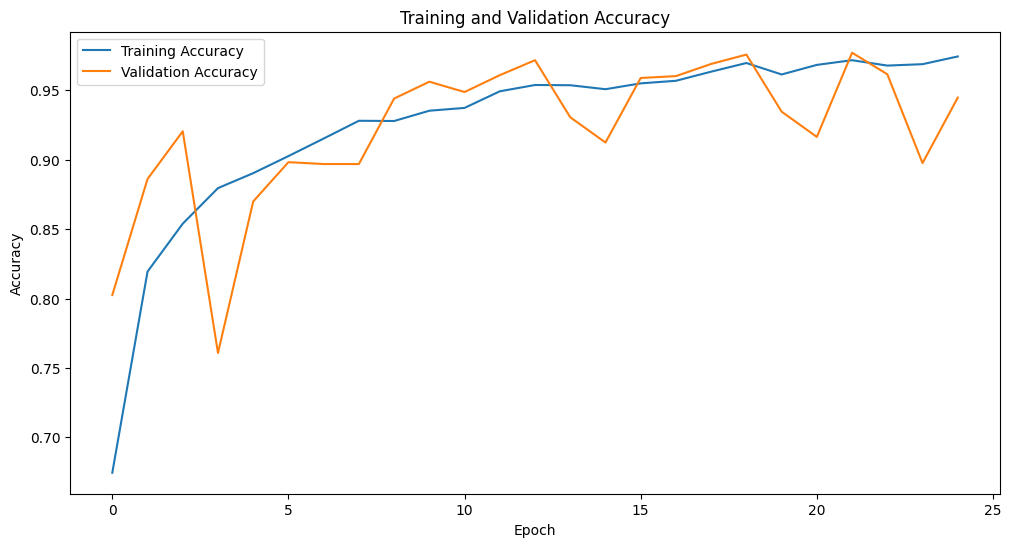

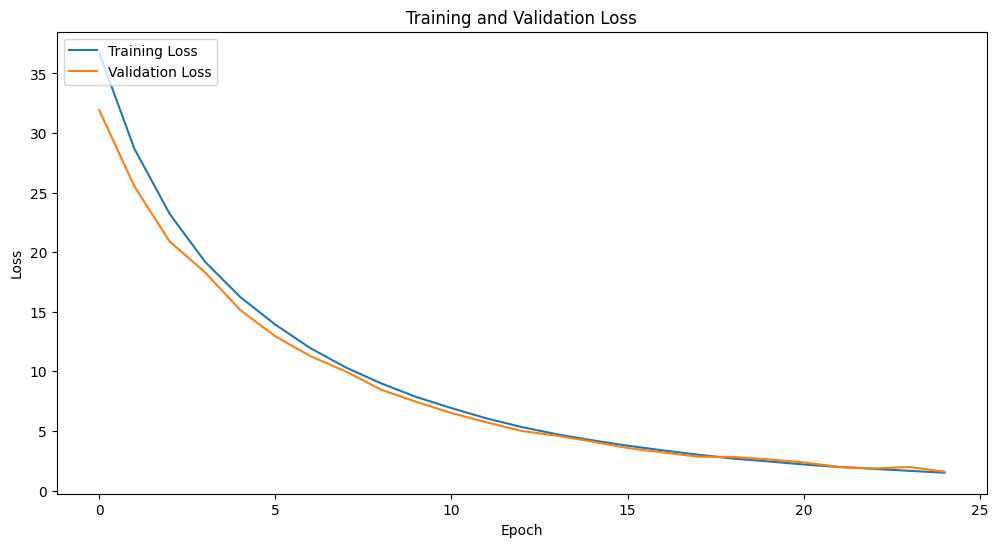

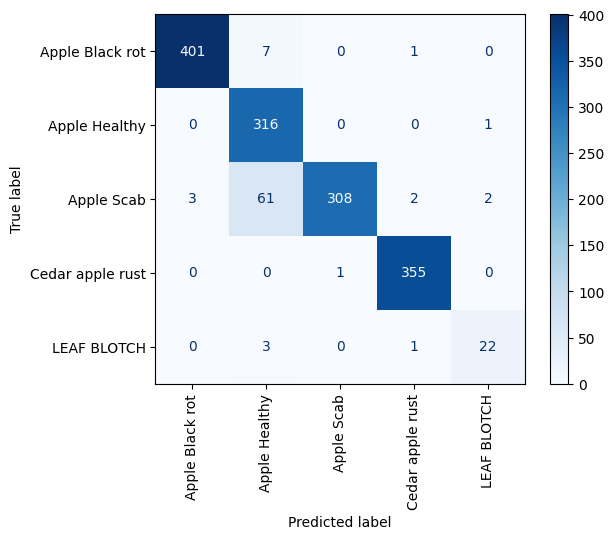

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot training & validation accuracy and loss
def plot_metrics(history):
    if 'accuracy' in history.history and 'val_accuracy' in history.history:
        plt.figure(figsize=(12, 6))
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(loc='upper left')
        plt.title('Training and Validation Accuracy')
        plt.show()
    else:
        print("No accuracy data found in history object")

    if 'loss' in history.history and 'val_loss' in history.history:
        plt.figure(figsize=(12, 6))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(loc='upper left')
        plt.title('Training and Validation Loss')
        plt.show()
    else:
        print("No loss data found in history object")

plot_metrics(history)

# Plot confusion matrix with vertical labels
def plot_confusion_matrix(cm, class_names):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

plot_confusion_matrix(cm, label_encoder.classes_)

47/47 ━━━━━━━━━━━━━━━━━━━━ 28s 605ms/step


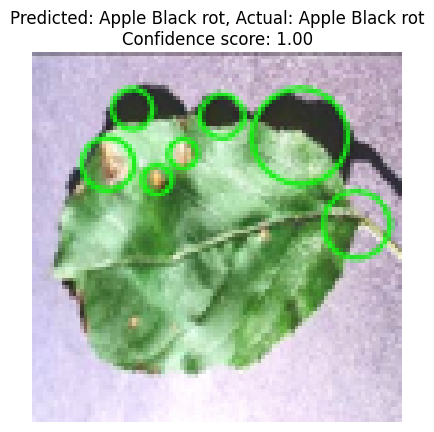

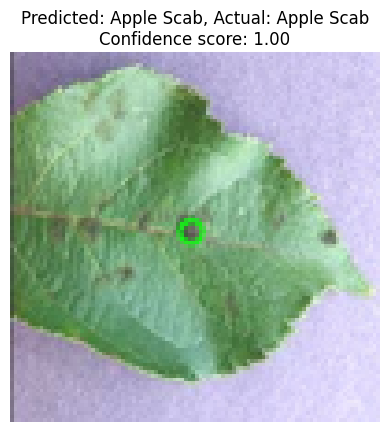

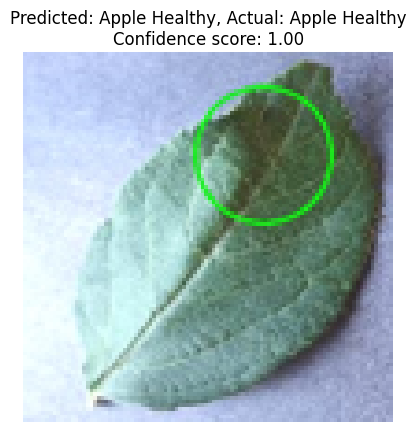

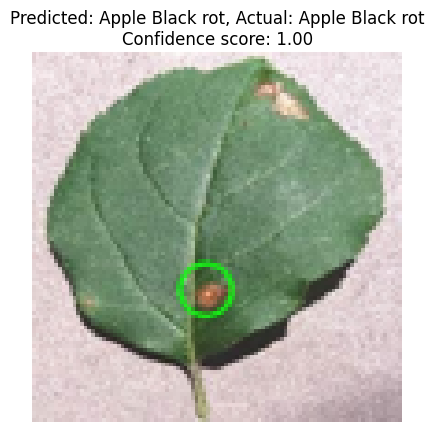

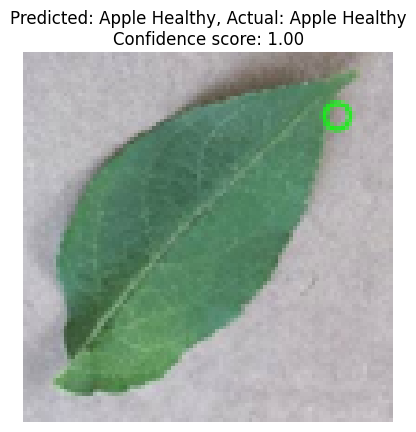

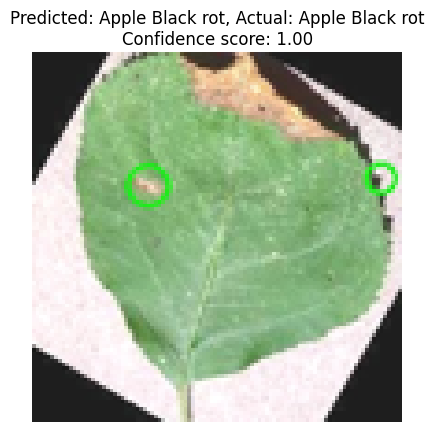

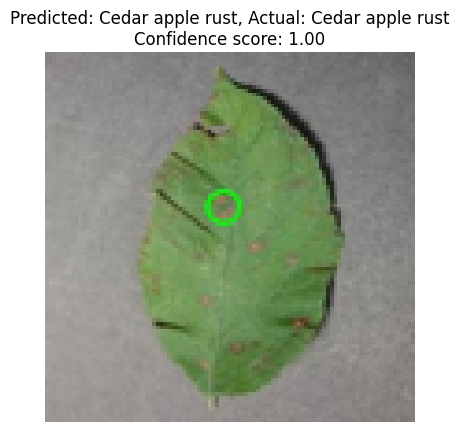

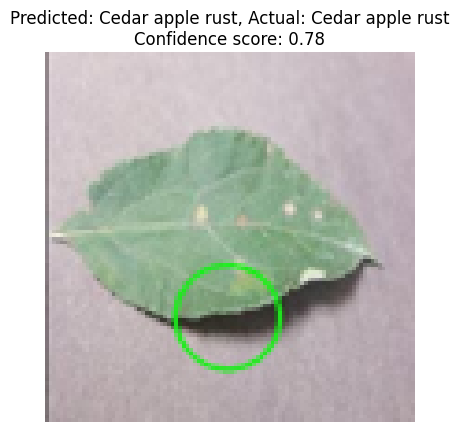

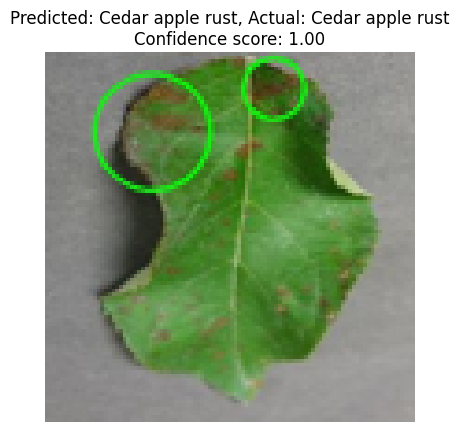

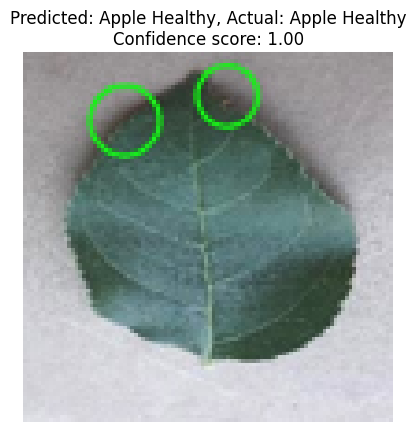

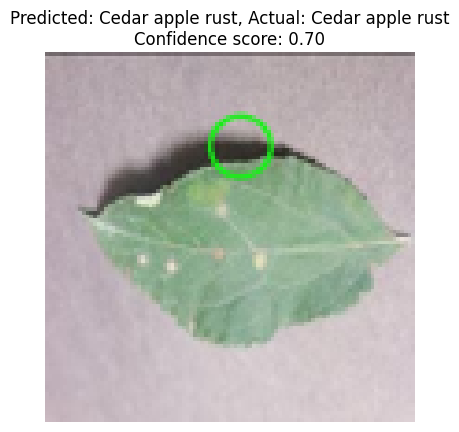

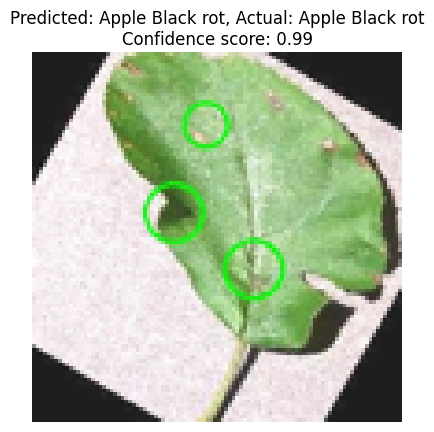

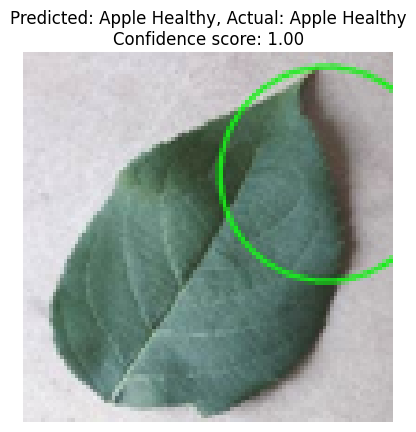

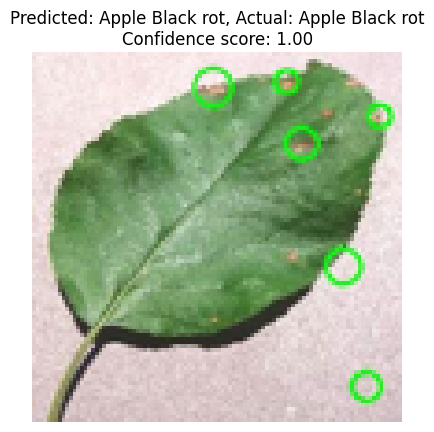

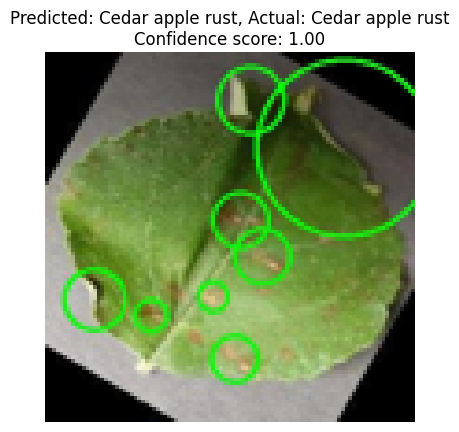

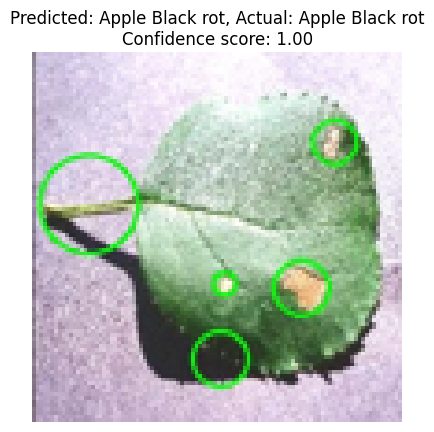

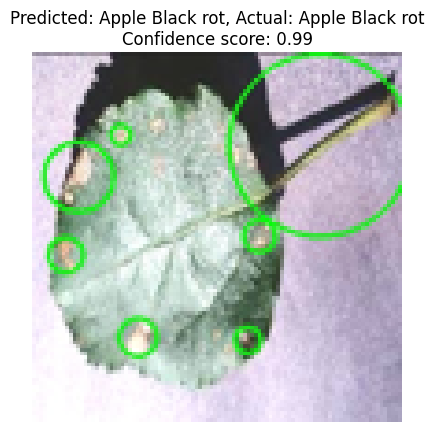

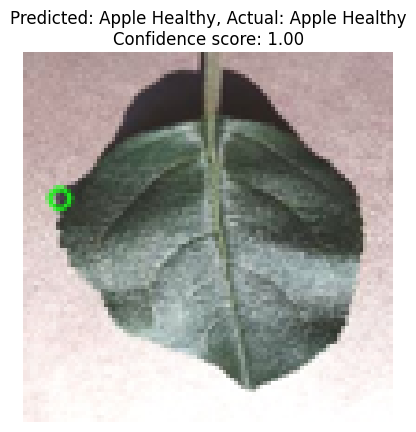

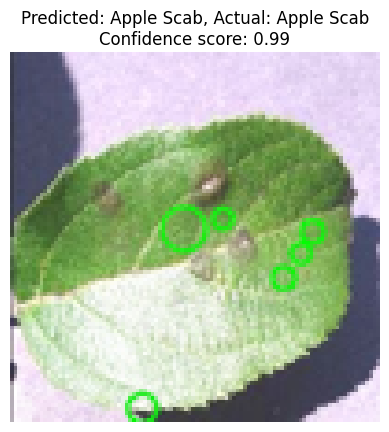

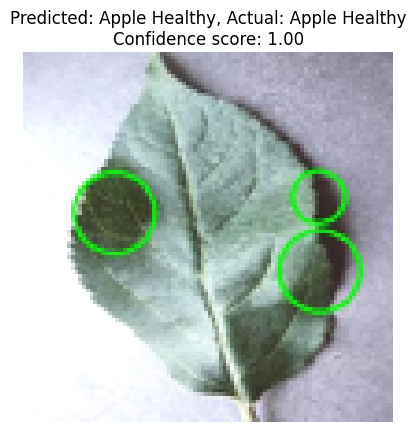

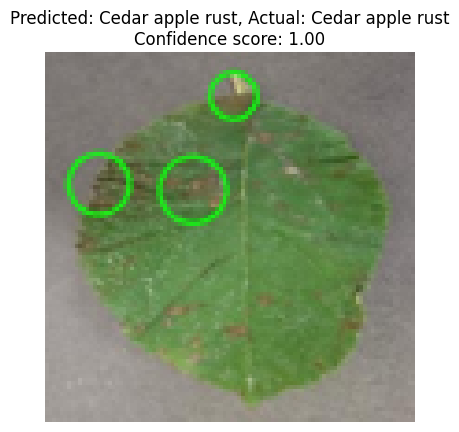

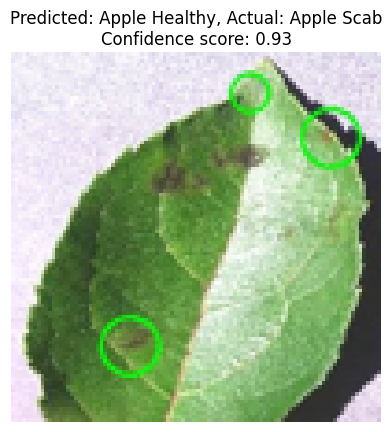

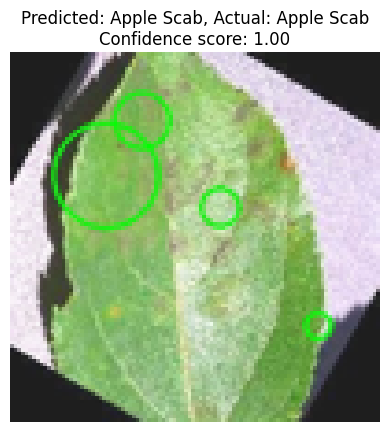

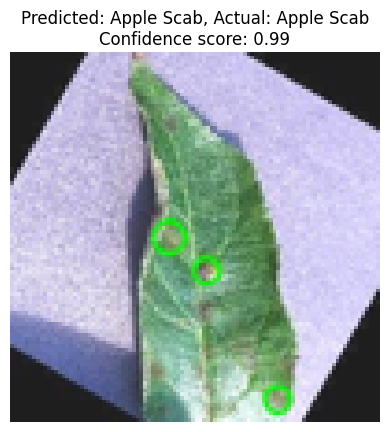

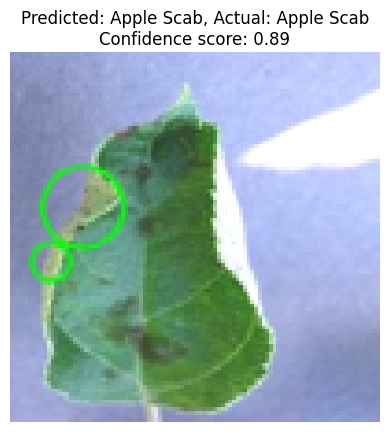

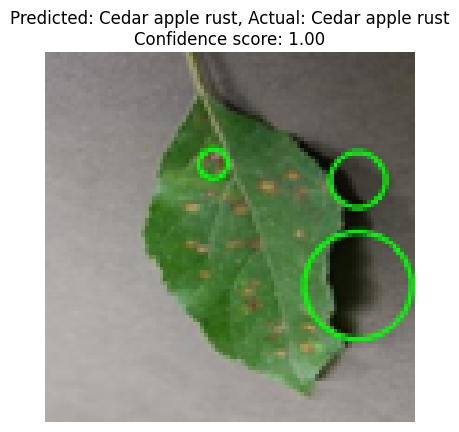

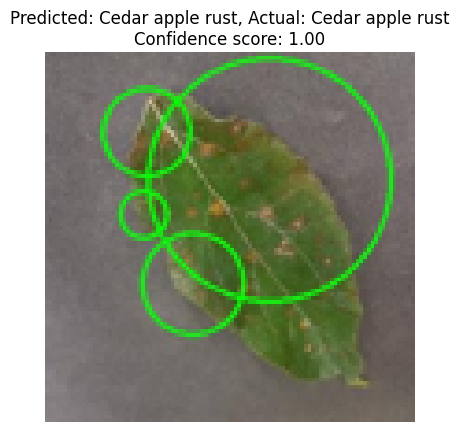

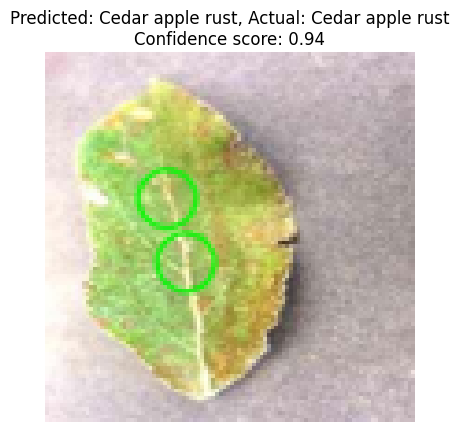

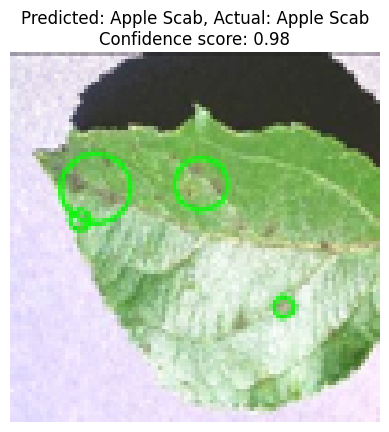

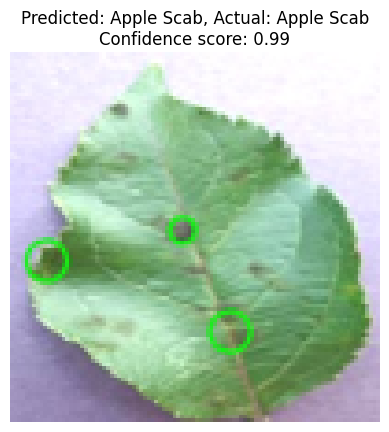

In [4]:
import matplotlib.pyplot as plt
import random
# Function to display image with predicted label and confidence score
def display_image_with_prediction(index, predicted_label, actual_label, confidence_score):
    image = X_test[index]
    plt.imshow(image.astype(np.uint8))
    plt.title(f"Predicted: {predicted_label}, Actual: {actual_label}\nConfidence score: {confidence_score:.2f}")
    plt.axis('off')
    plt.show()

# Randomly select 3 images from the test set
random_indices = random.sample(range(len(X_test)), 30)

# Predict probabilities for all test images
y_pred_proba = model.predict(X_test)

for idx in random_indices:
    predicted_class = np.argmax(y_pred_proba[idx])  # Get predicted class index
    confidence_score = y_pred_proba[idx][predicted_class]  # Get confidence score for predicted class
    predicted_label = label_encoder.inverse_transform([predicted_class])[0]  # Convert to label
    actual_label = label_encoder.inverse_transform([y_true[idx]])[0]  # Actual label
    
    display_image_with_prediction(idx, predicted_label, actual_label, confidence_score)

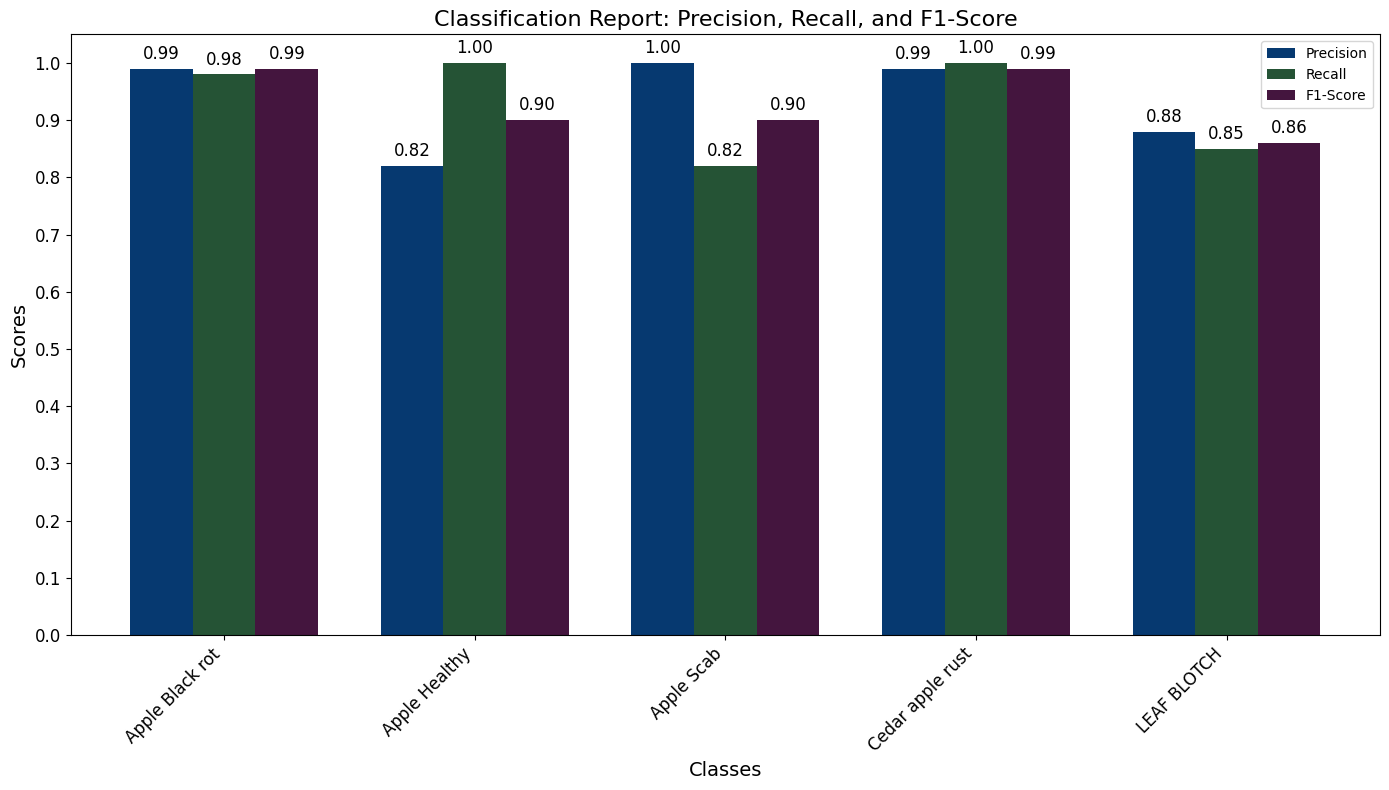

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Data from the classification report
classes = ['Apple Black rot', 'Apple Healthy', 'Apple Scab', 'Cedar apple rust', 'LEAF BLOTCH']
precision = [0.99, 0.82, 1.00, 0.99, 0.88]
recall = [0.98, 1.00, 0.82, 1.00, 0.85]
f1_score = [0.99, 0.90, 0.90, 0.99, 0.86]

# Set up the bar chart plot
bar_width = 0.25  # width of bars
index = np.arange(len(classes))  # x-axis positions for the bars

# Create the figure and axis
plt.figure(figsize=(14, 8))

# Plotting the bars for precision, recall, and f1 score with updated colors
bar1 = plt.bar(index - bar_width, precision, bar_width, label='Precision', color='#063970')  # Blue
bar2 = plt.bar(index, recall, bar_width, label='Recall', color='#255335')  # Green
bar3 = plt.bar(index + bar_width, f1_score, bar_width, label='F1-Score', color='#44153E')  # Dark Red

# Adding labels and title
plt.xlabel('Classes', fontsize=14)
plt.ylabel('Scores', fontsize=14)
plt.title('Classification Report: Precision, Recall, and F1-Score', fontsize=16)
plt.xticks(index, classes, rotation=45, ha='right', fontsize=12)
plt.yticks(np.arange(0, 1.1, 0.1), fontsize=12)
plt.legend()

# Adding annotations (display precision, recall, f1-score values on the bars)
def add_annotations(bars, values):
    for bar, value in zip(bars, values):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f'{value:.2f}', ha='center', va='bottom', fontsize=12)

add_annotations(bar1, precision)
add_annotations(bar2, recall)
add_annotations(bar3, f1_score)

# Improve layout for better visibility
plt.tight_layout()

# Show the plot
plt.show()


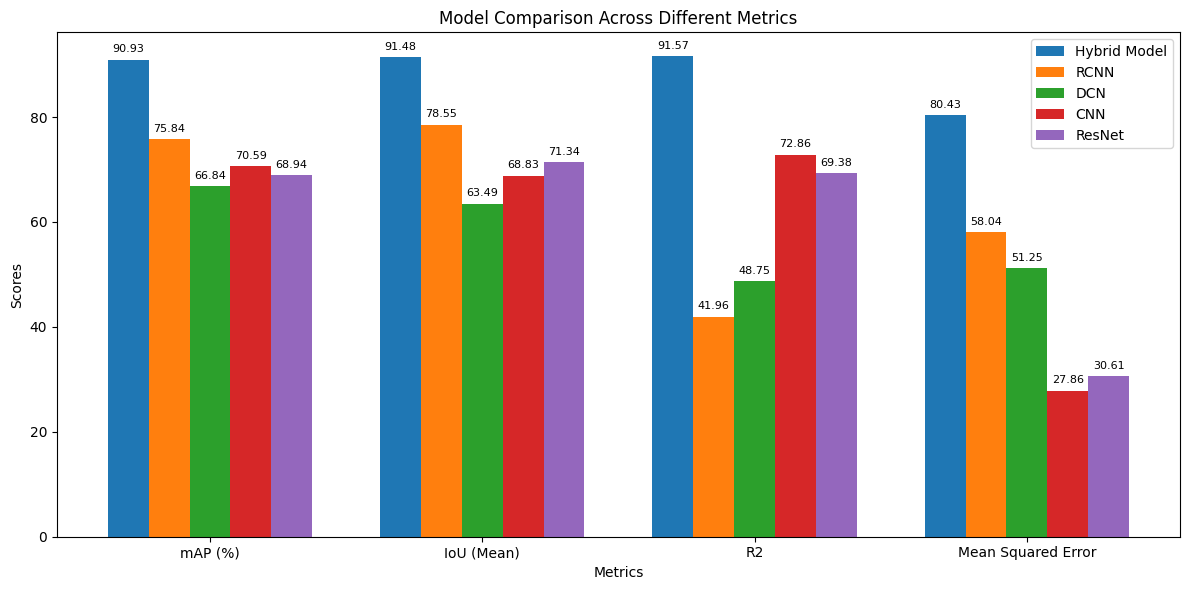

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['Hybrid Model', 'RCNN', 'DCN', 'CNN', 'ResNet']
metrics = ['mAP (%)', 'IoU (Mean)', 'R2', 'Mean Squared Error']

# Metric values for each model
values = {
    'Hybrid Model': [90.93, 91.48, 91.57, 80.43],
    'RCNN': [75.84, 78.55, 41.96, 58.04],
    'DCN': [66.84, 63.49, 48.75, 51.25],
    'CNN': [70.59, 68.83, 72.86, 27.86],
    'ResNet': [68.94, 71.34, 69.38, 30.61]
}

# Plotting
x = np.arange(len(metrics))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))

# Create bars for each model and annotate
for i, model in enumerate(models):
    bars = ax.bar(x + i * width, values[model], width, label=model)
    # Annotate each bar with the exact value
    for bar, value in zip(bars, values[model]):
        ax.text(
            bar.get_x() + bar.get_width() / 2,  # x-coordinate
            bar.get_height() + 1,              # y-coordinate (slightly above the bar)
            f'{value:.2f}',                    # Value to display
            ha='center', va='bottom', fontsize=8, color='black'
        )

# Add labels, title, and custom x-axis tick labels
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Model Comparison Across Different Metrics')
ax.set_xticks(x + width * 2)  # Adjust tick positions
ax.set_xticklabels(metrics)
ax.legend()

plt.tight_layout()
plt.show()

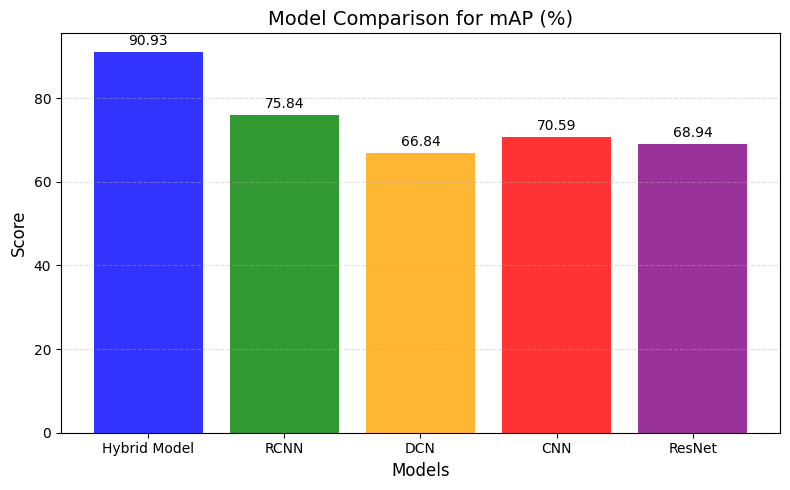

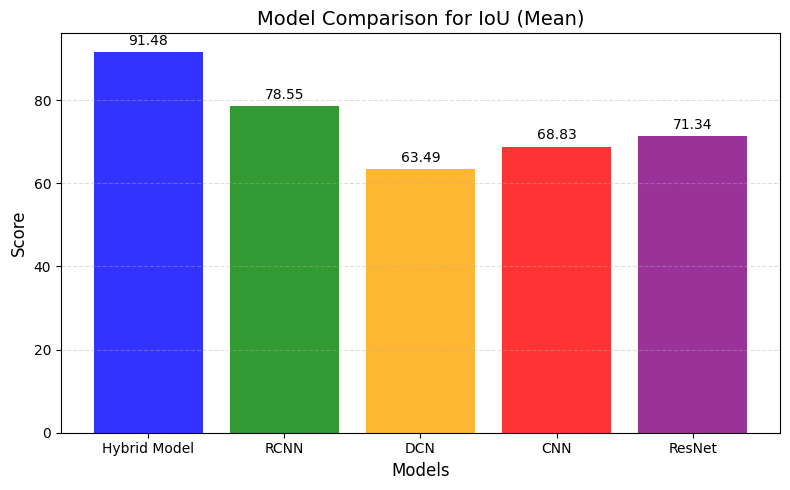

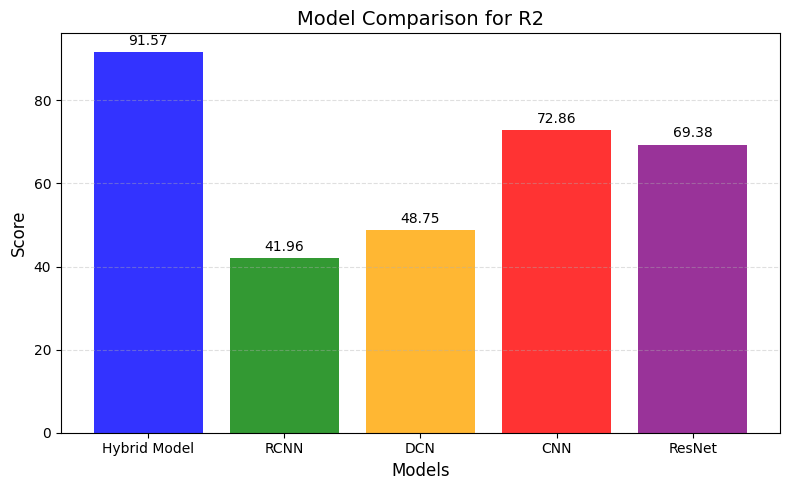

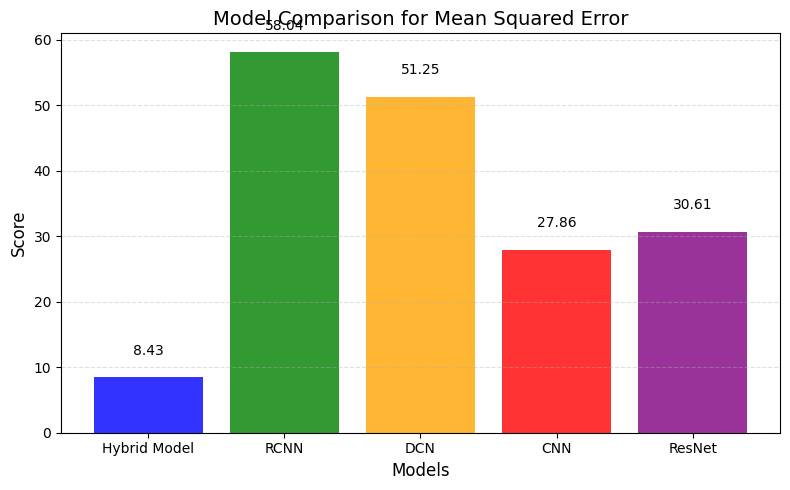

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['Hybrid Model', 'RCNN', 'DCN', 'CNN', 'ResNet']
metrics = ['mAP (%)', 'IoU (Mean)', 'R2', 'Mean Squared Error']

# Metric values for each model
values = {
    'Hybrid Model': [90.93, 91.48, 91.57, 8.43],
    'RCNN': [75.84, 78.55, 41.96, 58.04],
    'DCN': [66.84, 63.49, 48.75, 51.25],
    'CNN': [70.59, 68.83, 72.86, 27.86],
    'ResNet': [68.94, 71.34, 69.38, 30.61]
}

# Metric-specific values for plotting
metric_values = list(zip(*values.values()))  # Transpose values into metric-wise lists

# Create separate plots for each metric
for i, metric in enumerate(metrics):
    plt.figure(figsize=(8, 5))
    plt.bar(models, metric_values[i], color=['blue', 'green', 'orange', 'red', 'purple'], alpha=0.8)
    
    # Annotate each bar with the metric value
    for j, value in enumerate(metric_values[i]):
        plt.text(j, value + (1 if metric != 'Mean Squared Error' else 3), 
                 f'{value:.2f}', ha='center', va='bottom', fontsize=10)

    # Add titles and labels
    plt.title(f'Model Comparison for {metric}', fontsize=14)
    plt.ylabel('Score', fontsize=12)
    plt.xlabel('Models', fontsize=12)
    plt.grid(axis='y', alpha=0.4, linestyle='--')
    plt.tight_layout()
    plt.show()

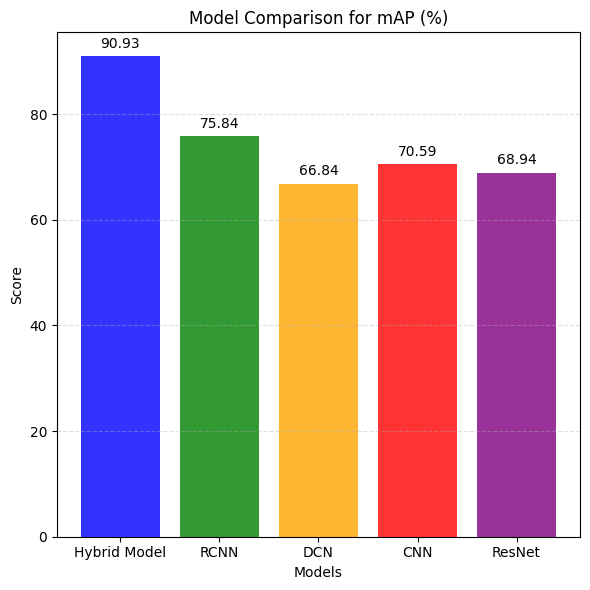

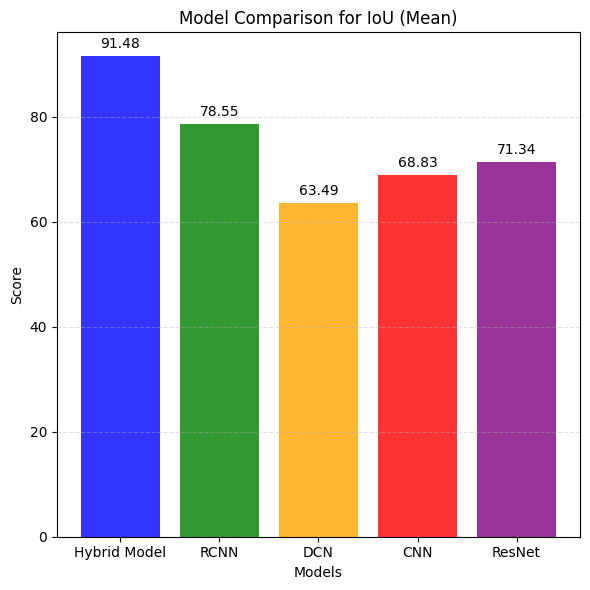

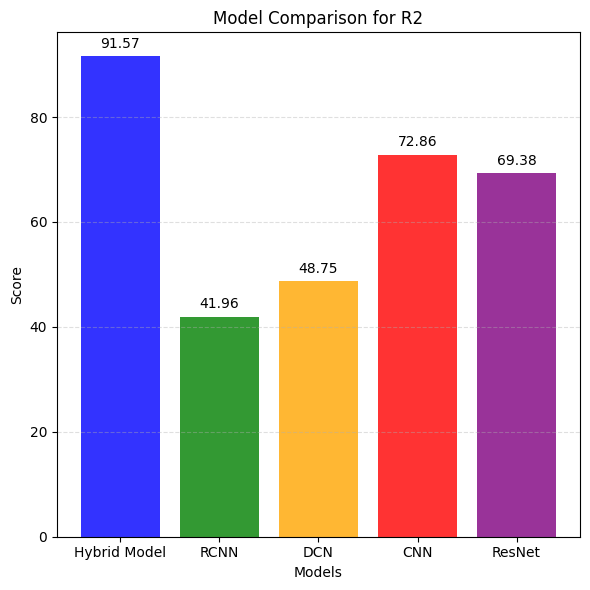

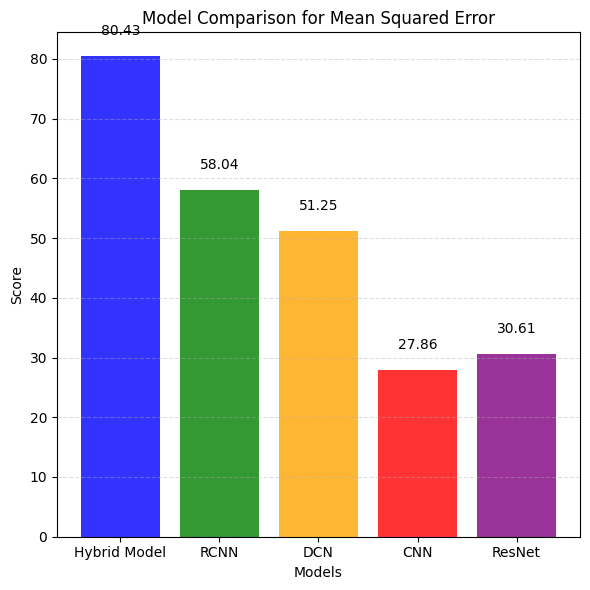

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['Hybrid Model', 'RCNN', 'DCN', 'CNN', 'ResNet']
metrics = ['mAP (%)', 'IoU (Mean)', 'R2', 'Mean Squared Error']

# Metric values for each model
values = {
    'Hybrid Model': [90.93, 91.48, 91.57, 80.43],
    'RCNN': [75.84, 78.55, 41.96, 58.04],
    'DCN': [66.84, 63.49, 48.75, 51.25],
    'CNN': [70.59, 68.83, 72.86, 27.86],
    'ResNet': [68.94, 71.34, 69.38, 30.61]
}

# Metric-specific values for plotting
metric_values = list(zip(*values.values()))  # Transpose values into metric-wise lists

# Create separate plots for each metric
for i, metric in enumerate(metrics):
    plt.figure(figsize=(6, 6))  # Smaller figure size (width=6, height=4)
    plt.bar(models, metric_values[i], color=['blue', 'green', 'orange', 'red', 'purple'], alpha=0.8)
    
    # Annotate each bar with the metric value
    for j, value in enumerate(metric_values[i]):
        plt.text(j, value + (1 if metric != 'Mean Squared Error' else 3), 
                 f'{value:.2f}', ha='center', va='bottom', fontsize=10)

    # Add titles and labels
    plt.title(f'Model Comparison for {metric}', fontsize=12)
    plt.ylabel('Score', fontsize=10)
    plt.xlabel('Models', fontsize=10)
    plt.grid(axis='y', alpha=0.4, linestyle='--')
    plt.tight_layout()
    plt.show()

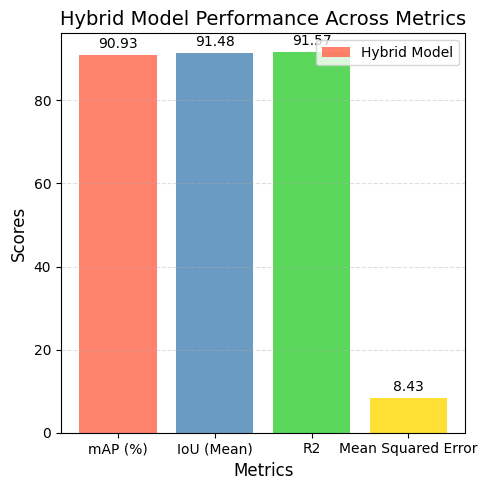

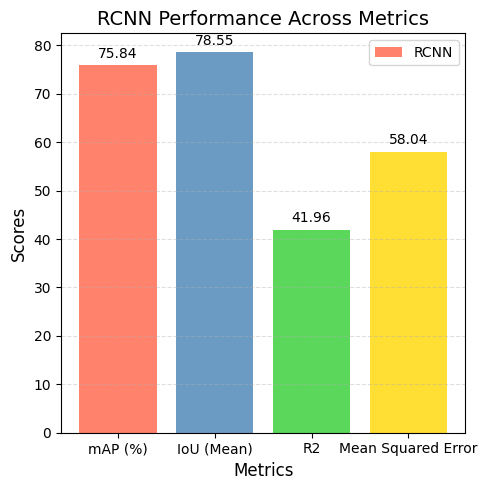

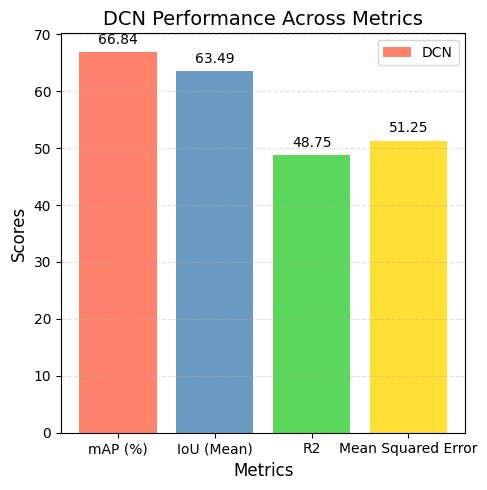

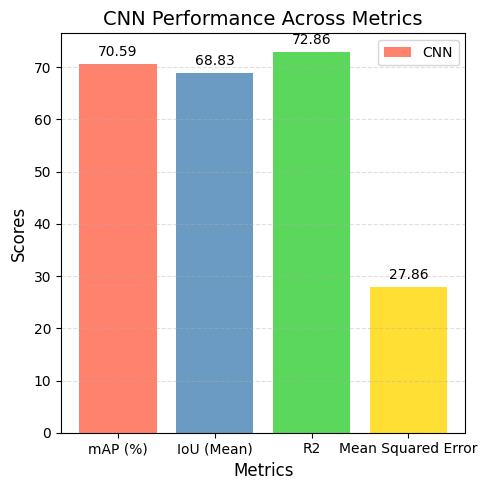

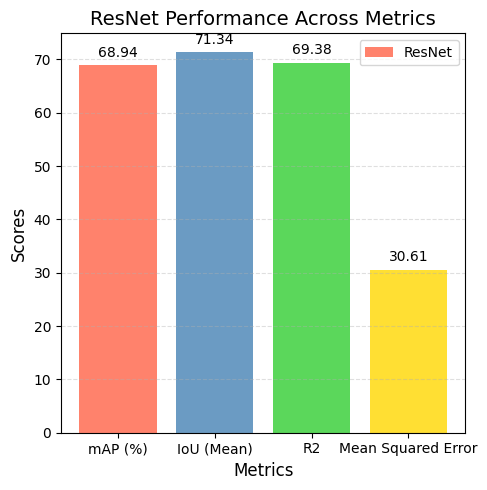

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['Hybrid Model', 'RCNN', 'DCN', 'CNN', 'ResNet']
metrics = ['mAP (%)', 'IoU (Mean)', 'R2', 'Mean Squared Error']

# Metric values for each model
values = {
    'Hybrid Model': [90.93, 91.48, 91.57, 8.43],
    'RCNN': [75.84, 78.55, 41.96, 58.04],
    'DCN': [66.84, 63.49, 48.75, 51.25],
    'CNN': [70.59, 68.83, 72.86, 27.86],
    'ResNet': [68.94, 71.34, 69.38, 30.61]
}

# Define a list of colors for each bar
colors = ['#FF6347', '#4682B4', '#32CD32', '#FFD700']  # Different colors for each bar

# Create separate bar plots for each model
for model in models:
    plt.figure(figsize=(5,5))  # Adjust the size for each plot
    
    # Create bars for each metric for the current model with individual colors
    bars = plt.bar(metrics, values[model], color=colors, alpha=0.8)
    
    # Annotate each bar with the exact value
    for i, value in enumerate(values[model]):
        plt.text(
            i, value + 1, f'{value:.2f}', ha='center', va='bottom', fontsize=10, color='black'
        )
    
    # Add labels, title, and grid
    plt.xlabel('Metrics', fontsize=12)
    plt.ylabel('Scores', fontsize=12)
    plt.title(f'{model} Performance Across Metrics', fontsize=14)
    plt.grid(axis='y', alpha=0.4, linestyle='--')
    
    # Add a legend with a smaller box size
    plt.legend([model], loc='upper right', fontsize=10, markerscale=0.5, handlelength=2)
    
    # Adjust layout
    plt.tight_layout()
    
    # Display the plot
    plt.show()

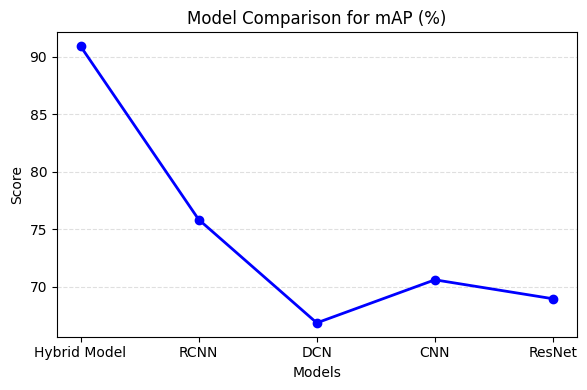

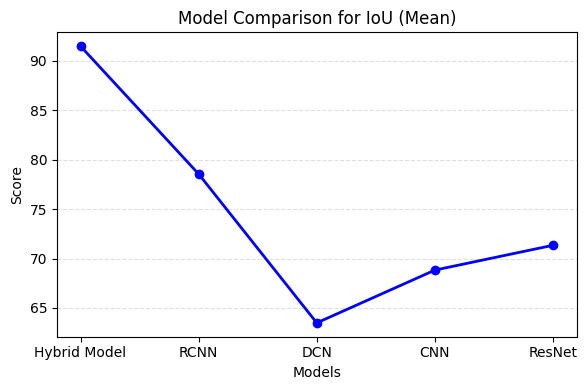

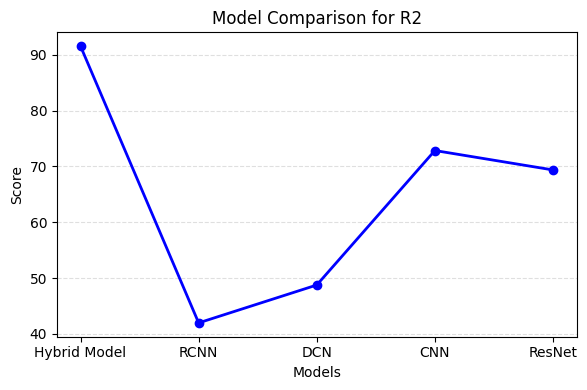

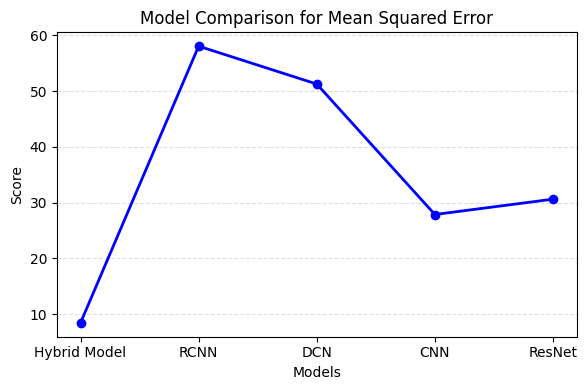

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['Hybrid Model', 'RCNN', 'DCN', 'CNN', 'ResNet']
metrics = ['mAP (%)', 'IoU (Mean)', 'R2', 'Mean Squared Error']

# Metric values for each model
values = {
    'Hybrid Model': [90.93, 91.48, 91.57, 8.43],
    'RCNN': [75.84, 78.55, 41.96, 58.04],
    'DCN': [66.84, 63.49, 48.75, 51.25],
    'CNN': [70.59, 68.83, 72.86, 27.86],
    'ResNet': [68.94, 71.34, 69.38, 30.61]
}

# Metric-specific values for plotting
metric_values = list(zip(*values.values()))  # Transpose values into metric-wise lists

# Create separate plots for each metric
for i, metric in enumerate(metrics):
    plt.figure(figsize=(6, 4))  # Smaller figure size (width=6, height=4)
    
    # Plot each model's data as a straight line with dots at the values
    plt.plot(models, metric_values[i], linestyle='-', marker='o', color='b', linewidth=2)  # Line with dots at points
    
    # Add titles and labels
    plt.title(f'Model Comparison for {metric}', fontsize=12)
    plt.ylabel('Score', fontsize=10)
    plt.xlabel('Models', fontsize=10)
    
    # Display grid
    plt.grid(axis='y', alpha=0.4, linestyle='--')
    
    # Tight layout
    plt.tight_layout()
    
    # Show the plot
    plt.show()
